Bibliotecas carregadas.

--- Iniciando Leitura Automática ---
Lendo pasta 'fotos/Limpas'...
Lendo pasta 'fotos/Sujas'...
------------------------------
Total Imagens Limpas: 30
Total Imagens Sujas:  159
TOTAL GERAL:          189
------------------------------

--- Preparando Dados (Split, Scaler, PCA) ---
PCA automático: Reduziu de 16384 para 16 features.

--- Treinando Modelos ---
Treinando KNN...
Treinando SVM...
Treinamento concluído.

--- Tabela de Métricas ---
  Modelo  Acurácia  Precisão    Recall  F1-Score
0    KNN  0.947368  0.978723  0.958333  0.968421
1    SVM  0.982456  0.979592  1.000000  0.989691


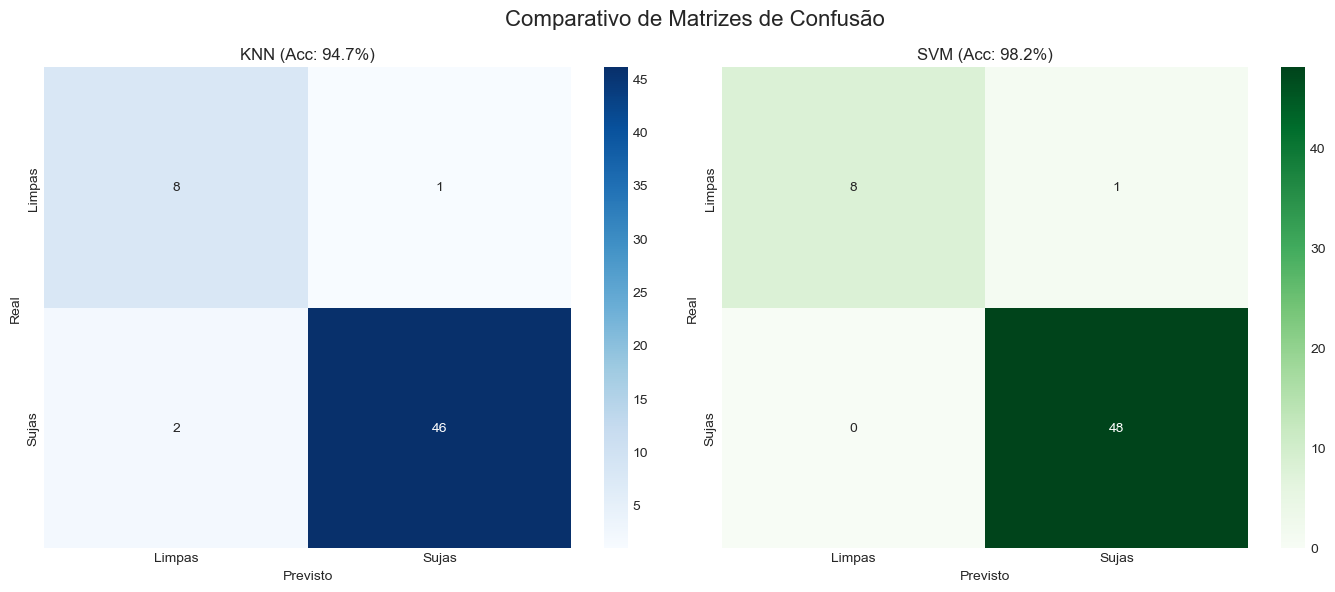

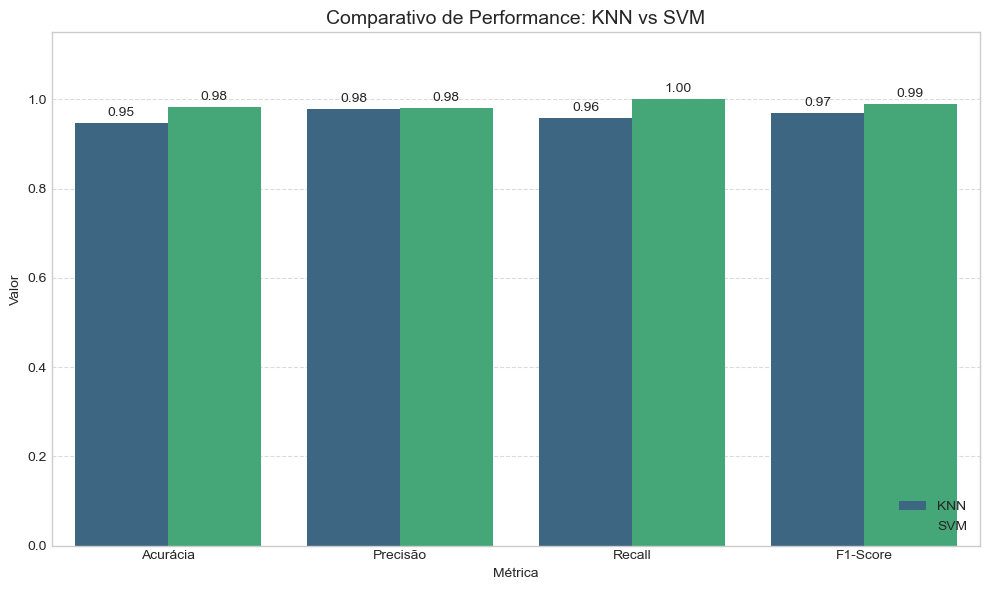


Processo finalizado com sucesso!


In [4]:
# ==============================================================================
# PARTE 1: IMPORTAÇÕES E CONFIGURAÇÕES
# ==============================================================================
import os

# --- CORREÇÃO DE ERRO DE PROCESSADOR (WinError 2 do Windows) ---
# Força o uso de 4 núcleos para evitar que o sklearn tente contar e falhe
os.environ['LOKY_MAX_CPU_COUNT'] = '4' 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Algoritmos e Processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Configurações Visuais
plt.style.use('seaborn-v0_8-whitegrid') 
IMAGE_SIZE = (128, 128) # Tamanho para redimensionar (padrão 128x128 é bom e rápido)

print("Bibliotecas carregadas.")

# ==============================================================================
# PARTE 2: CARREGAMENTO AUTOMÁTICO (LÊ TUDO DA PASTA)
# ==============================================================================
X = []
y = []
classes = ['Limpas', 'Sujas']
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp') # Extensões aceitas

def carregar_pasta_inteira(diretorio, label_id):
    """
    Lê TODOS os arquivos válidos de uma pasta e adiciona à lista X e y.
    """
    count = 0
    if not os.path.exists(diretorio):
        print(f"AVISO: A pasta '{diretorio}' não existe!")
        return 0

    # Lista todos os arquivos da pasta
    arquivos = os.listdir(diretorio)
    
    for arquivo in arquivos:
        # Verifica se é imagem
        if arquivo.lower().endswith(valid_extensions):
            path_completo = os.path.join(diretorio, arquivo)
            
            try:
                img = cv2.imread(path_completo)
                
                if img is not None:
                    # Pré-processamento padrão
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, IMAGE_SIZE)
                    
                    X.append(img.flatten())
                    y.append(label_id)
                    count += 1
            except Exception as e:
                print(f"Erro ao ler {arquivo}: {e}")
    
    return count

print("\n--- Iniciando Leitura Automática ---")

# 1. Carrega pasta LIMPAS (Classe 0)
print("Lendo pasta 'fotos/Limpas'...")
qtd_limpas = carregar_pasta_inteira('fotos/Limpas', 0)

# 2. Carrega pasta SUJAS (Classe 1)
print("Lendo pasta 'fotos/Sujas'...")
qtd_sujas = carregar_pasta_inteira('fotos/Sujas', 1)

print("-" * 30)
print(f"Total Imagens Limpas: {qtd_limpas}")
print(f"Total Imagens Sujas:  {qtd_sujas}")
print(f"TOTAL GERAL:          {qtd_limpas + qtd_sujas}")
print("-" * 30)

X = np.array(X)
y = np.array(y)

# Validação se temos dados suficientes
if len(np.unique(y)) < 2:
    print("\nERRO CRÍTICO: Não encontrei imagens nas duas classes.")
    print("Verifique se as pastas 'fotos/Limpas' e 'fotos/Sujas' existem e têm fotos.")
else:
    # ==============================================================================
    # PARTE 3: PREPARAÇÃO (SPLIT, NORMALIZAÇÃO E PCA)
    # ==============================================================================
    print("\n--- Preparando Dados (Split, Scaler, PCA) ---")

    # 1. Divisão Treino/Teste (70% Treino, 30% Teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 2. Normalização (Obrigatório para SVM e KNN)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 3. PCA (Reduzir complexidade)
    # Tenta manter 95% da informação. Se der erro (poucas fotos), usa 2 componentes.
    try:
        pca = PCA(n_components=0.95, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print(f"PCA automático: Reduziu de {X_train.shape[1]} para {X_train_pca.shape[1]} features.")
    except:
        pca = PCA(n_components=2, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print("PCA Fallback (2 componentes) ativado.")

    # ==============================================================================
    # PARTE 4: TREINAMENTO DOS MODELOS
    # ==============================================================================
    print("\n--- Treinando Modelos ---")

    # --- KNN ---
    print("Treinando KNN...")
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(X_train_pca, y_train)
    y_pred_knn = knn.predict(X_test_pca)

    # --- SVM ---
    print("Treinando SVM...")
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    svm.fit(X_train_pca, y_train)
    y_pred_svm = svm.predict(X_test_pca)

    print("Treinamento concluído.")

    # ==============================================================================
    # PARTE 5: RESULTADOS E GRÁFICOS (PARA O TCC)
    # ==============================================================================

    def get_metrics(y_true, y_pred, model_name):
        return {
            'Modelo': model_name,
            'Acurácia': accuracy_score(y_true, y_pred),
            'Precisão': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0)
        }

    metrics_knn = get_metrics(y_test, y_pred_knn, 'KNN')
    metrics_svm = get_metrics(y_test, y_pred_svm, 'SVM')
    df_metrics = pd.DataFrame([metrics_knn, metrics_svm])

    print("\n--- Tabela de Métricas ---")
    print(df_metrics)

    # --- GRÁFICO 1: MATRIZES DE CONFUSÃO ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Comparativo de Matrizes de Confusão', fontsize=16)

    # KNN Heatmap
    sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title(f'KNN (Acc: {metrics_knn["Acurácia"]:.1%})')
    axes[0].set_ylabel('Real')
    axes[0].set_xlabel('Previsto')

    # SVM Heatmap
    sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=classes, yticklabels=classes)
    axes[1].set_title(f'SVM (Acc: {metrics_svm["Acurácia"]:.1%})')
    axes[1].set_ylabel('Real')
    axes[1].set_xlabel('Previsto')

    plt.tight_layout()
    plt.savefig('comparativo_matriz_confusao.png', dpi=300)
    plt.show()

    # --- GRÁFICO 2: BARRAS DE PERFORMANCE ---
    df_melted = df_metrics.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_melted, x="Métrica", y="Valor", hue="Modelo", palette="viridis")

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.title('Comparativo de Performance: KNN vs SVM', fontsize=14)
    plt.ylim(0, 1.15)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('comparativo_metricas_barras.png', dpi=300)
    plt.show()

    print("\nProcesso finalizado com sucesso!")